# Parameter quantification using a combination of CNN and LSTM

Import Dependencies

In [48]:
from pylab import *
from sklearn.utils import shuffle
from sklearn import preprocessing
import matplotlib.pyplot as plt
from scipy import stats
import sys
import pickle
import scipy.io
import pandas as pd
sys.path.insert(0, '../src')

%matplotlib inline
import h5py

import numpy as np
import tensorflow as tf
import keras
import random as rn
from keras import regularizers
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,BatchNormalization, Concatenate


from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Flatten, Dropout, Activation
from keras.layers.convolutional import Conv1D, ZeroPadding2D, MaxPooling1D
from keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from keras.layers.core import Reshape 


print(tf.__version__)

import os
os.environ['PYTHONHASHSEED'] = '0'

np.random.seed(42)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.random.set_seed(12345)

sees = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sees)

2.9.3


Utility functions

In [49]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['mse'])
    mse = smooth_curve(history.history['mae'][:steps])
    val_mse = smooth_curve(history.history['val_mae'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])
    
    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(mse, c='#0c7cba', label='Early stop train')
    plt.plot(val_mse, c='#0f9d58', label='Early stop Val')
    plt.xticks(range(0, len(mse), 5))
    plt.xlim(0, len(mse))
    plt.title('Train mae: %.3f, Val mae: %.3f' % (mse[-1], val_mse[-1]), fontsize=12)
    plt.legend()

def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history



Load Data

In [50]:
import glob
cest_array_path = '/mnt/yadav_lab_backup/vdsouza1/Lorentzian_data_preds/z*.csv'
cest_array_paths = sorted(glob.glob(cest_array_path))
map_array_path = '/mnt/yadav_lab_backup/vdsouza1/Lorentzian_data_preds/f*.csv'
map_array_paths = sorted(glob.glob(map_array_path))
print(len(cest_array_paths),len(map_array_paths))

15 15


In [51]:
cest_array_dict =[]
for i in range(len(cest_array_paths)):
    b = cest_array_paths[i].split('pca_')[1][:-4]
    string = "simulationMatrix_" + b 
    
    my_dict = {string:pd.read_csv(cest_array_paths[i])}
    cest_array_dict.append(my_dict)

In [52]:
map_array_dict =[]
for i in range(len(map_array_paths)):
    b = map_array_paths[i].split('pca_')[1][:-4]
    string = "trainingDataIndex_" + b 
    
    my_dict = {string:pd.read_csv(map_array_paths[i])}
    map_array_dict.append(my_dict)

In [53]:
#to split into test(20%)-train(80%)
train_list = [0,1,2,3,4,5,9,10,11,12,13,14]
test_list =[6,7,8]

Create train and test input and output(true labels) matrices

In [54]:
for i in range(len(test_list)-1):
    if i==0:
        simulationMatrix_test = pd.concat([cest_array_dict[test_list[0]]["simulationMatrix_" + cest_array_paths[test_list[i]].split('pca_')[1][:-4]],cest_array_dict[test_list[1]]["simulationMatrix_" + cest_array_paths[test_list[i+1]].split('pca_')[1][:-4]]])    
    else:
        simulationMatrix_test = pd.concat([simulationMatrix_test,cest_array_dict[test_list[i+1]]["simulationMatrix_" + cest_array_paths[test_list[i+1]].split('pca_')[1][:-4]]])    

In [55]:
for i in range(len(train_list)-1):
    if i==0:
        simulationMatrix_train = pd.concat([cest_array_dict[train_list[0]]["simulationMatrix_" + cest_array_paths[train_list[i]].split('pca_')[1][:-4]],cest_array_dict[train_list[1]]["simulationMatrix_" + cest_array_paths[train_list[i+1]].split('pca_')[1][:-4]]])    
    else:
        simulationMatrix_train = pd.concat([simulationMatrix_train,cest_array_dict[train_list[i+1]]["simulationMatrix_" + cest_array_paths[train_list[i+1]].split('pca_')[1][:-4]]])    

In [56]:
for i in range(len(test_list)-1):
    if i == 0:
        trainingDataIndex_test = pd.concat([map_array_dict[test_list[0]]["trainingDataIndex_" + map_array_paths[test_list[i]].split('pca_')[1][:-4]],map_array_dict[test_list[1]]["trainingDataIndex_" + map_array_paths[test_list[i+1]].split('pca_')[1][:-4]]])   
    else:
        trainingDataIndex_test = pd.concat([trainingDataIndex_test,map_array_dict[test_list[i+1]]["trainingDataIndex_" + map_array_paths[test_list[i+1]].split('pca_')[1][:-4]]])

In [57]:
for i in range(len(train_list)-1):
    if i == 0:
        trainingDataIndex_train = pd.concat([map_array_dict[train_list[0]]["trainingDataIndex_" + map_array_paths[train_list[i]].split('pca_')[1][:-4]],map_array_dict[train_list[1]]["trainingDataIndex_" + map_array_paths[train_list[i+1]].split('pca_')[1][:-4]]])   
    else:
        trainingDataIndex_train = pd.concat([trainingDataIndex_train,map_array_dict[train_list[i+1]]["trainingDataIndex_" + map_array_paths[train_list[i+1]].split('pca_')[1][:-4]]])

Following is done to accurately store indices to reconstruct every slice from 1d predictions of the model

In [58]:
test_map_indices = [0]
for i in range(len(test_list)-1):
    if i == 0:
        test_map_indices.append(cest_array_dict[test_map_indices[-1] + test_list[0]]["simulationMatrix_" + cest_array_paths[test_list[0]].split('pca_')[1][:-4]].shape[0])
        test_map_indices.append(test_map_indices[-1] + cest_array_dict[test_list[1]]["simulationMatrix_" + cest_array_paths[test_list[1]].split('pca_')[1][:-4]].shape[0])
#         trainingDataIndex_test = pd.concat([map_array_dict[test_list[0]]["trainingDataIndex_" + map_array_paths[test_list[i]].split('_pca_')[1][:-4]],map_array_dict[test_list[1]]["trainingDataIndex_" + map_array_paths[test_list[i+1]].split('_pca_')[1][:-4]]])   
    else:
        test_map_indices.append(test_map_indices[-1] + cest_array_dict[test_list[i+1]]["simulationMatrix_" + cest_array_paths[test_list[i+1]].split('pca_')[1][:-4]].shape[0])
#         trainingDataIndex_test = pd.concat([trainingDataIndex_test,map_array_dict[test_list[i+1]]["trainingDataIndex_" + map_array_paths[test_list[i+1]].split('_pca_')[1][:-4]]])

In [59]:
train_map_indices = [0]
for i in range(len(train_list)-1):
    if i == 0:
        train_map_indices.append(cest_array_dict[train_map_indices[-1] + train_list[0]]["simulationMatrix_" + cest_array_paths[train_list[0]].split('pca_')[1][:-4]].shape[0])
        train_map_indices.append(train_map_indices[-1] + cest_array_dict[train_list[1]]["simulationMatrix_" + cest_array_paths[train_list[1]].split('pca_')[1][:-4]].shape[0])
#         trainingDataIndex_train = pd.concat([map_array_dict[train_list[0]]["trainingDataIndex_" + map_array_paths[train_list[i]].split('_pca_')[1][:-4]],map_array_dict[train_list[1]]["trainingDataIndex_" + map_array_paths[train_list[i+1]].split('_pca_')[1][:-4]]])   
    else:
        train_map_indices.append(train_map_indices[-1] + cest_array_dict[train_list[i+1]]["simulationMatrix_" + cest_array_paths[train_list[i+1]].split('pca_')[1][:-4]].shape[0])
#         trainingDataIndex_train = pd.concat([trainingDataIndex_train,map_array_dict[train_list[i+1]]["trainingDataIndex_" + map_array_paths[train_list[i+1]].split('_pca_')[1][:-4]]])

For now prediction of only amplitude of amide parameter is shown as  an example

In [60]:
trainingDataIndex_train = np.asarray(trainingDataIndex_train)[:,3].reshape(-1,1)
trainingDataIndex_test = np.asarray(trainingDataIndex_test)[:,3].reshape(-1,1)
simulationMatrix_train = np.asarray(simulationMatrix_train).reshape(-1,56)
simulationMatrix_test = np.asarray(simulationMatrix_test).reshape(-1,56)

In [61]:
# np.asarray(trainingDataIndex_train)[:,6].reshape(-1,1)

In [62]:
# np.asarray(trainingDataIndex_train)[:,6].reshape(-1,1)

In [63]:
print(simulationMatrix_train.shape, trainingDataIndex_train.shape)
print(simulationMatrix_test.shape, trainingDataIndex_test.shape)

(113860, 56) (113860, 1)
(32892, 56) (32892, 1)


In [64]:
trainX = simulationMatrix_train
trainy = trainingDataIndex_train
testX = simulationMatrix_test
testy = trainingDataIndex_test
trainy.shape

(113860, 1)

In [65]:
def build_model(trainX, trainy):
    
    K.clear_session()
           
    NN_model = Sequential()
    # The Input Layer :
    Input = trainX.shape[1]
    NN_model.add(Conv1D(filters=32, kernel_size = 3, input_shape = (trainX.shape[1],1,), activation='relu'))
    NN_model.add(Conv1D(filters=32, kernel_size = 3,activation='relu'))
    NN_model.add(Conv1D(filters=64, kernel_size = 3,activation='relu'))
    NN_model.add(MaxPooling1D(pool_size=1,strides = 2))
    NN_model.add(LSTM(100))
#     NN_model.add(Dense(32, Input_shape = (Input,), kernel_initializer='normal', activation='tanh'))
    NN_model.add(Dense(100, kernel_initializer='normal', activation='tanh'))
    NN_model.add(Dense(32, kernel_initializer='normal', activation='tanh'))
    NN_model.add(Dense(32, kernel_initializer='normal', activation='tanh'))
    NN_model.add(Dense(32, kernel_initializer='normal', activation='tanh'))
#     # The Output Layer :
    NN_model.add(Dense(1,activation="linear"))   
    adam = tf.optimizers.Adam(learning_rate=1e-6)
# #                                  , beta_1=0.9, beta_2=0.999)
    NN_model.compile(loss='mse', optimizer=adam, metrics = ['mse','mae'])
    print(NN_model.summary())
              
    return NN_model

In [66]:
#scaling outputs to be (0,1) range
from sklearn import preprocessing


scalerY = preprocessing.MinMaxScaler(feature_range=(0,1))
scalerY.fit(trainy)
trainy_standard = scalerY.transform(trainy)

# trainy_standard = trainy

print (trainy_standard.shape)

(113860, 1)


In [24]:
def evaluate_model(X, y):
    verbose, epochs, batch_size = 1, 200, 64
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
#     patience: Number of epochs with no improvement after which training will be stopped.
    model = build_model(X, y)
    history = model.fit(X, y, validation_split=0.2,
                    epochs=epochs, batch_size=batch_size, verbose=verbose,
                       callbacks=[early_stop]) 

    model.save_weights('model_weights.h5')
        
    save_history(history, 'history.bin')
    return model, history

In [25]:
# CNN training
import time

start_time = time.process_time()

model, early_history = evaluate_model(trainX, trainy)

print (time.process_time() - start_time, "seconds")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 54, 32)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 52, 32)            3104      
                                                                 
 conv1d_2 (Conv1D)           (None, 50, 64)            6208      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 64)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                        

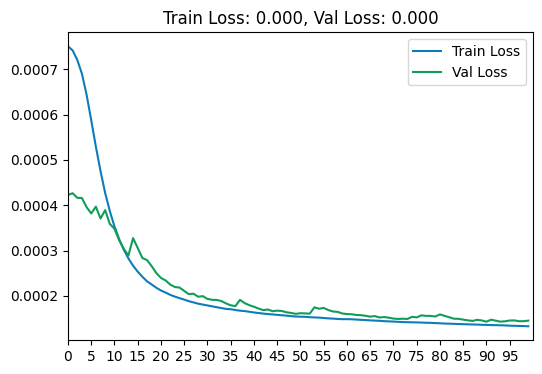

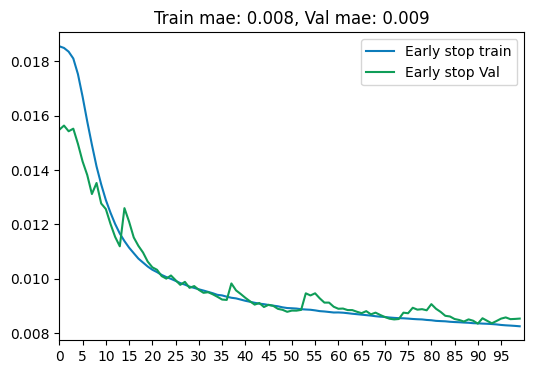

In [26]:
#check performance history
plot_compare(early_history, steps=100)

In [34]:
#generate predictions
import sys
import numpy
from sklearn import metrics


all_preds = model.predict(testX) 
preds = model.predict(trainX)


2659/2659 [==============================] - 14s 5ms/step


In [35]:

#rescaling and rmse calculation
all_preds_rescale = scalerY.inverse_transform(all_preds)#[:,0].reshape(-1,1))
preds_rescale = scalerY.inverse_transform(preds)#[:,0].reshape(-1,1))
print('mean_squared_error: %f' % (metrics.mean_squared_error(testy, all_preds_rescale)))

rmse = sqrt(metrics.mean_squared_error(testy,all_preds_rescale))
print('Test RMSE: %.3f' % rmse)



mean_squared_error: 0.000859
Test RMSE: 0.029


Mapping the predicted amplitude values to each slice and saving it

In [42]:
map_dict_test =[]
for i in range(len(test_list)):
    string = 'test_preds_'+ cest_array_paths[test_list[i]].split('a_')[1][:-4]
    my_dict = {string:all_preds[test_map_indices[i]:test_map_indices[i+1]]}
    map_dict_test.append(my_dict)

In [43]:
map_dict_train =[]
for i in range(len(train_list)):
    string = 'train_preds_'+ cest_array_paths[train_list[i]].split('a_')[1][:-4]
    my_dict = {string:preds_rescale[train_map_indices[i]:train_map_indices[i+1]]}
    map_dict_train.append(my_dict)

In [44]:
for i in range(len(map_dict_train)):
    b = map_dict_train[i]["train_preds_"+cest_array_paths[train_list[i]].split('a_')[1][:-4]]
    b = pd.DataFrame(b)
    b.to_csv('/mnt/yadav_lab_backup/vdsouza1/Lorentzian_data_preds/Predictions/'+ cest_array_paths[train_list[i]].split('a_')[1][:-4]+'.csv', index=False)    

In [45]:
for i in range(len(map_dict_test)):
    b = map_dict_test[i]["test_preds_"+cest_array_paths[test_list[i]].split('a_')[1][:-4]]
    b = pd.DataFrame(b)
    b.to_csv('/mnt/yadav_lab_backup/vdsouza1/Lorentzian_data_preds/Predictions/'+ cest_array_paths[test_list[i]].split('a_')[1][:-4]+'.csv', index=False)    

# Prediction maps shown in data preprocessing notebook